In [642]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm
import time

In [643]:
equity_data = yf.download("RR.L", start="2021-11-27", end="2023-11-27")
equity_data = pd.DataFrame(equity_data['Adj Close'])
equity_data


[*********************100%%**********************]  1 of 1 completed


,Adj Close
Date,
2021-11-29,122.500000
2021-11-30,122.500000
2021-12-01,126.139999
2021-12-02,125.440002
2021-12-03,124.900002
...,...
2023-11-20,245.500000
2023-11-21,243.000000
2023-11-22,237.500000


In [644]:
equity_data.describe().round(3)

,Adj Close
count,501.000
mean,127.307
std,47.908
min,66.240
25%,88.430
50%,113.020
75%,151.050
max,245.500


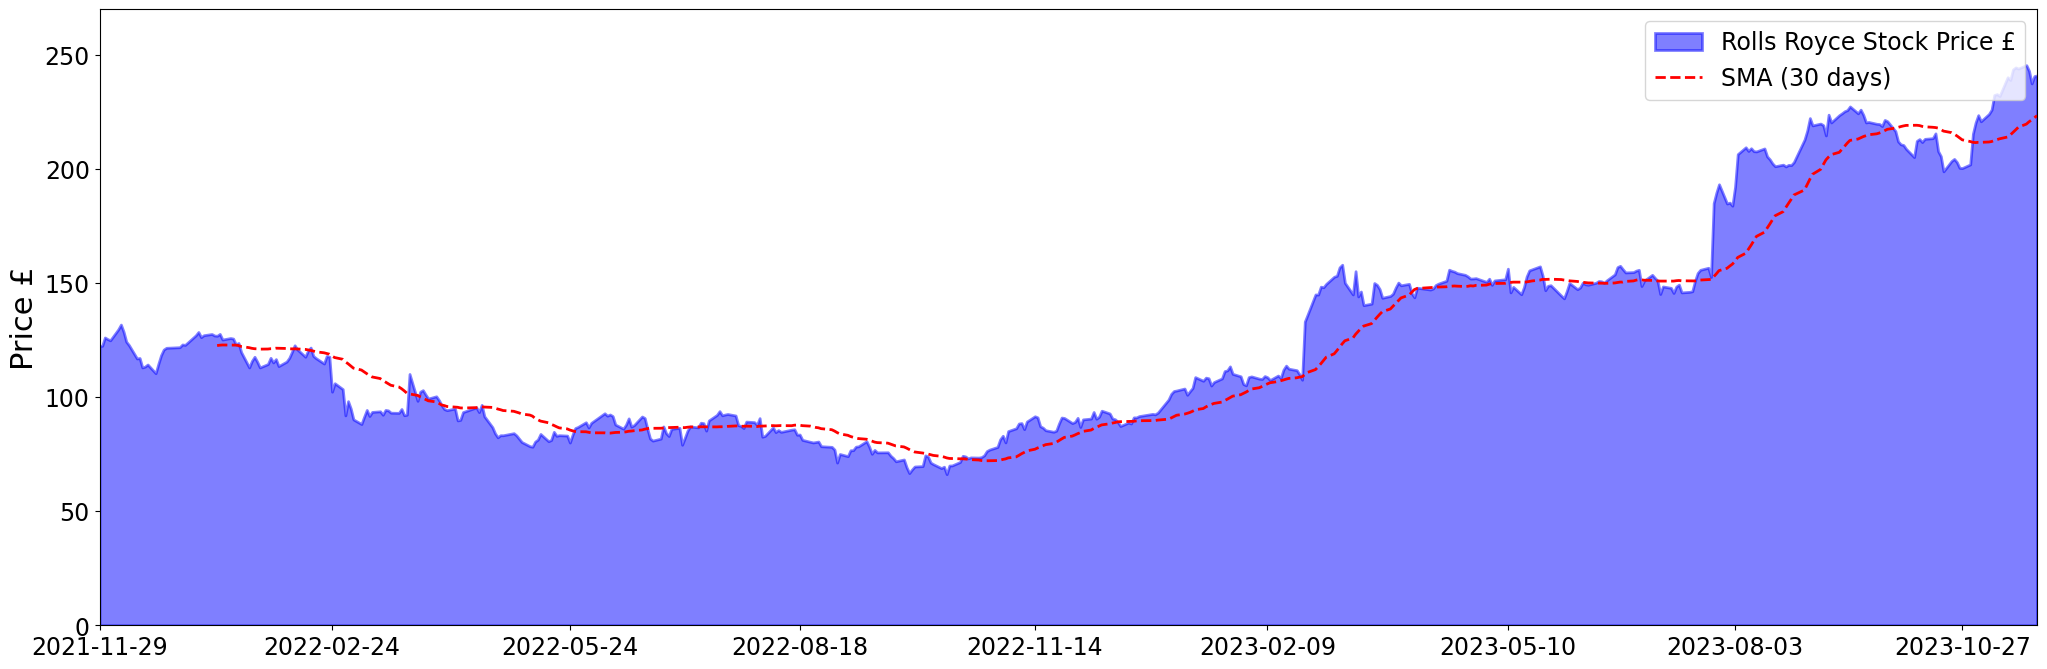

In [645]:
# Stock Prices Line Chart formatting
equity_data['SMA (30)'] = equity_data['Adj Close'].rolling(window=30).mean()
fig, ax = plt.subplots(figsize=(25,8), dpi= 100)
ax.fill_between(equity_data.index, y1=equity_data['Adj Close'], y2=0, label="Rolls Royce Stock Price £", alpha=0.5, color='blue', linewidth=2)
ax.plot(equity_data.index, equity_data['SMA (30)'], label=f'SMA ({30} days)', color='red', linestyle='--', linewidth=2)
ax.set(ylim=[0, 270], xlim=[equity_data.index[0], equity_data.index[-1]])
ax.legend(loc='best', fontsize=17)
plt.xticks(equity_data.index[::60], fontsize=17, horizontalalignment='center')
plt.yticks(fontsize=17)
plt.ylabel('Price £', fontsize=22)

plt.show()

In [646]:
log_returns = np.log(equity_data['Adj Close']/equity_data['Adj Close'].shift(1))
log_returns.head().round(4)

Date
2021-11-29       NaN
2021-11-30    0.0000
2021-12-01    0.0293
2021-12-02   -0.0056
2021-12-03   -0.0043
Name: Adj Close, dtype: float64

In [647]:
daily_returns = equity_data['Adj Close'].dropna().pct_change()
daily_returns.head().round(4)

Date
2021-11-29       NaN
2021-11-30    0.0000
2021-12-01    0.0297
2021-12-02   -0.0055
2021-12-03   -0.0043
Name: Adj Close, dtype: float64

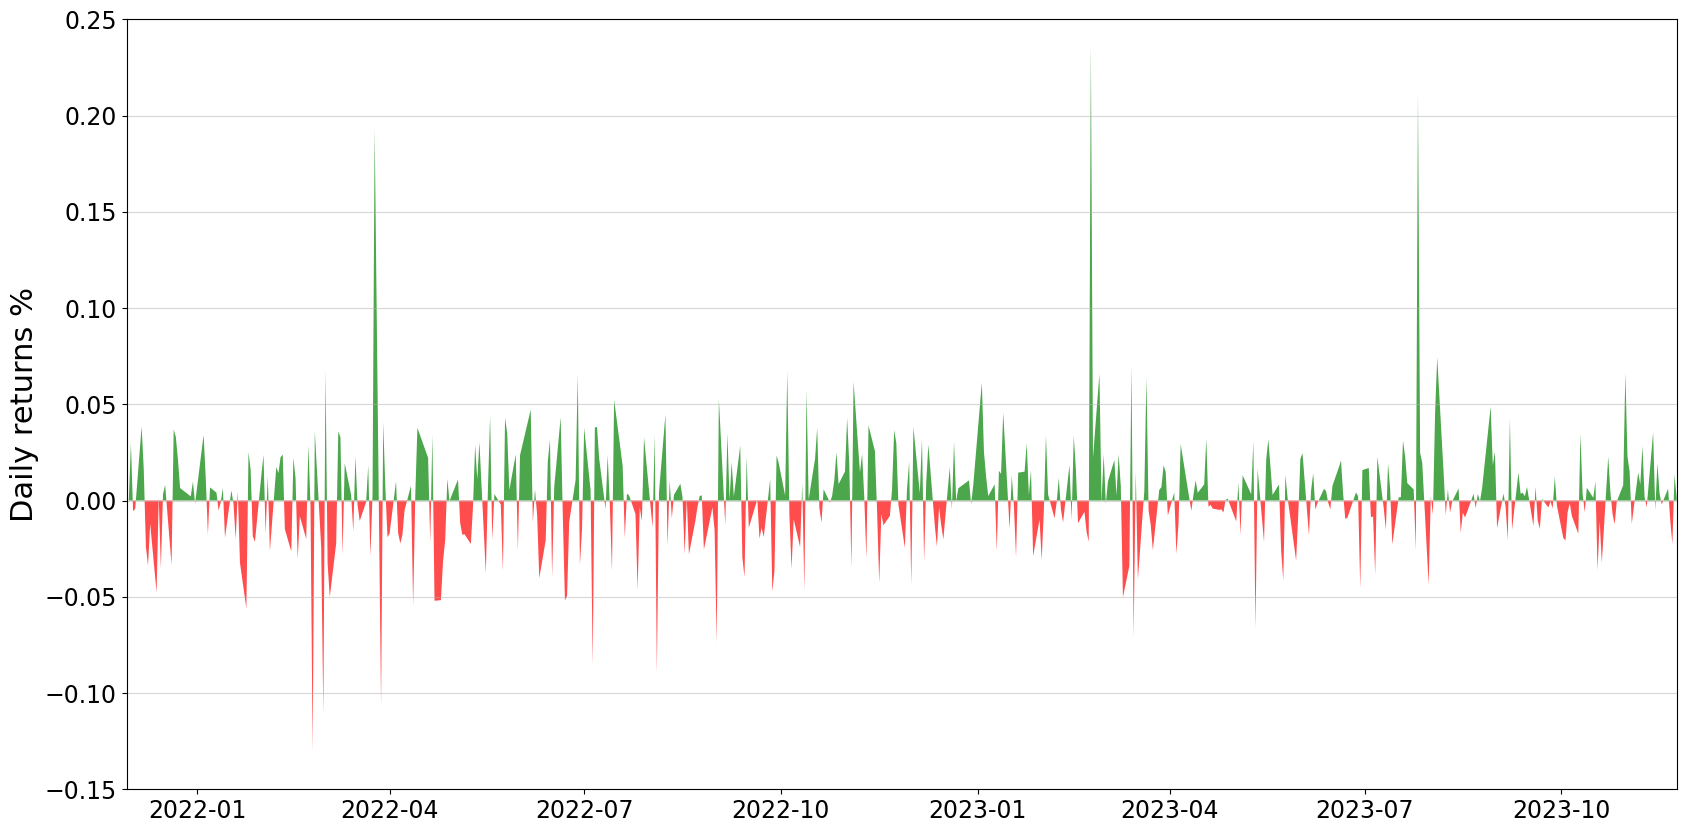

In [648]:

# Log Returns Line Chart formatting
plt.figure(figsize=(20,10))
plt.fill_between(x=daily_returns.index[1:],y1=daily_returns[1:],y2=0, where = daily_returns[1:]>=0, facecolor='green', interpolate=True, alpha=0.7)
plt.fill_between(x=daily_returns.index[1:],y1=daily_returns[1:],y2=0, where = daily_returns[1:]<=0, facecolor='red', interpolate=True, alpha=0.7)
plt.xlim(daily_returns.index[0], daily_returns.index[-1])
plt.ylim(-0.15,0.25)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
#plt.title("Rolls Royce daily returns %", fontsize=22)
plt.ylabel('Daily returns %', fontsize=22)
plt.grid(alpha=0.5, axis='y')
plt.show()


In [649]:
log_returns.describe().round(4)

count    500.0000
mean       0.0014
std        0.0302
min       -0.1394
25%       -0.0128
50%        0.0020
75%        0.0157
max        0.2125
Name: Adj Close, dtype: float64

In [650]:
daily_returns.describe().round(4)

count    500.0000
mean       0.0018
std        0.0308
min       -0.1302
25%       -0.0127
50%        0.0020
75%        0.0158
max        0.2368
Name: Adj Close, dtype: float64

In [651]:
avg_daily_returns = daily_returns.mean()
std_daily_returns = daily_returns.std()
annualised_avg_return = avg_daily_returns * 252 # annualised average returns = average daily ret * number of trading days
annualised_std = std_daily_returns * np.sqrt(252) # annualised std = returns std * sqrt of number of trading days
print(f'Annualised Average Returns --> {annualised_avg_return.round(4)}\nAnnualised Standard Deviation --> {annualised_std.round(4)}')


Annualised Average Returns --> 0.4574
Annualised Standard Deviation --> 0.4891


## Model Parameters

In [652]:
maturity = 0.5 # Time to Maturity in years
S0 = equity_data['Adj Close'].iloc[-1] # last Stock price
K = 200.6 #Strike Price
r = 0.025 #Risk-free rate
sigma = log_returns.std() * np.sqrt(252) #Volatility Rate
payoff = "put"
N = 4

# Black_scholes Model

In [653]:
def black_scholes_merton_model(time, stock_price, strike_price, risk_rate, volatility, payoff):
    
    d1 = (np.log(stock_price / strike_price) + (risk_rate + volatility**2 / 2) * time) / (volatility * np.sqrt(time))
    d2 = d1 - volatility * np.sqrt(time)

    if payoff == "call":
        option_price = norm.cdf(d1) * stock_price - norm.cdf(d2) * strike_price * np.exp(-risk_rate * time)
    elif payoff == "put":
        option_price = norm.cdf(-d2) * strike_price * np.exp(-risk_rate * time) - norm.cdf(-d1) * stock_price
    
    return option_price

In [654]:
BSM_price = black_scholes_merton_model(time=maturity,stock_price=S0,strike_price=K,risk_rate=r,volatility=sigma,payoff=payoff)
print(f'Rolls Royce European Put Option Price with BSM model--> {BSM_price.round(4)}')

Rolls Royce European Put Option Price with BSM model--> 12.8465


# Binomial Tree

### Step 1

In [655]:
dT = float(maturity) / N   # Time interval
up = np.exp(sigma * np.sqrt(dT))    # Up factor
down = 1.0 / up   # Down factor

# Building the stock forecast of the binomial tree
stock_forecast = np.zeros((N + 1, N + 1))
stock_forecast[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        stock_forecast[i, t] = stock_forecast[i, t-1] * up
        stock_forecast[i+1, t] = stock_forecast[i, t-1] * down
    z += 1
    
stock_forecast.round(4)

array([[241.    , 285.517 , 338.2571, 400.7392, 474.7628],
       [  0.    , 203.424 , 241.    , 285.517 , 338.2571],
       [  0.    ,   0.    , 171.7067, 203.424 , 241.    ],
       [  0.    ,   0.    ,   0.    , 144.9347, 171.7067],
       [  0.    ,   0.    ,   0.    ,   0.    , 122.3369]])

In [656]:
# Compuation of probabilities for stock changes

compound_r = np.exp(r * dT)    # risk free compound return
up_prob = (compound_r - down)/ (up - down)  # risk neutral probability of stock going up
down_prob = 1.0 - up_prob           # risk neutral probability of stock going down
print('Risk-neutral porbability of stock going up is --> ', up_prob.round(4))
print('Risk-neutral porbability of stock going down is --> ', down_prob.round(4))

Risk-neutral porbability of stock going up is -->  0.4669
Risk-neutral porbability of stock going down is -->  0.5331


### Step 2:

In [657]:
# Computation of option prices at maturity

stock_at_maturity = stock_forecast[:,-1] # Array with stock prices at maturity date
option_forecast = np.zeros((N + 1, N + 1))
if payoff =="call":
    option_forecast[:,-1] = np.maximum(stock_at_maturity-K, 0.0) # Call option price at maturity date = payoff of the option at maturity
elif payoff =="put":
    option_forecast[:,-1] = np.maximum(K-stock_at_maturity, 0.0) # Call option price at maturity date = payoff  of the option at maturity


option_forecast.round(4)

array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    , 28.8933],
       [ 0.    ,  0.    ,  0.    ,  0.    , 78.2631]])

### Step 3

In [658]:
# Computation to calculate European Option Price at each node of the tree

for j in range(N-1, -1, -1):
    for i in range(j+1):
        option_forecast[i,j] = np.exp(-r*dT) * (up_prob * option_forecast[i,j + 1] + down_prob * option_forecast[i + 1,j + 1])

option_forecast.round(4)

array([[14.3154,  4.3363,  0.    ,  0.    ,  0.    ],
       [ 0.    , 23.1398,  8.1598,  0.    ,  0.    ],
       [ 0.    ,  0.    , 36.3961, 15.3546,  0.    ],
       [ 0.    ,  0.    ,  0.    , 55.0394, 28.8933],
       [ 0.    ,  0.    ,  0.    ,  0.    , 78.2631]])

In [659]:
# the option price today is the price in the first node of the tree

BT_price = option_forecast[0,0]
print(f'Rolls Royce European Put Option Price with Binomial Tree model--> {BT_price.round(4)}')

Rolls Royce European Put Option Price with Binomial Tree model--> 14.3154


### Montecarlo Simulation

In [660]:
# This function generates n_sim possible stock trends from time 0 (now) to the maturity time of the option (T).
# for each path daily prices are generated (252 * years to maturity)

def mcs_simulation_np(n_sim):
    M = int(252*maturity) # number of time steps
    I = n_sim # number os paths
    dt = maturity / M 
    simulated_stocks = np.zeros((M + 1, I))
    simulated_stocks[0] = S0 
    rn = np.random.standard_normal(simulated_stocks.shape) 
    for t in range(1, M + 1): 
        simulated_stocks[t] = simulated_stocks[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return simulated_stocks

In [661]:
stocks_simulation = mcs_simulation_np(10000)

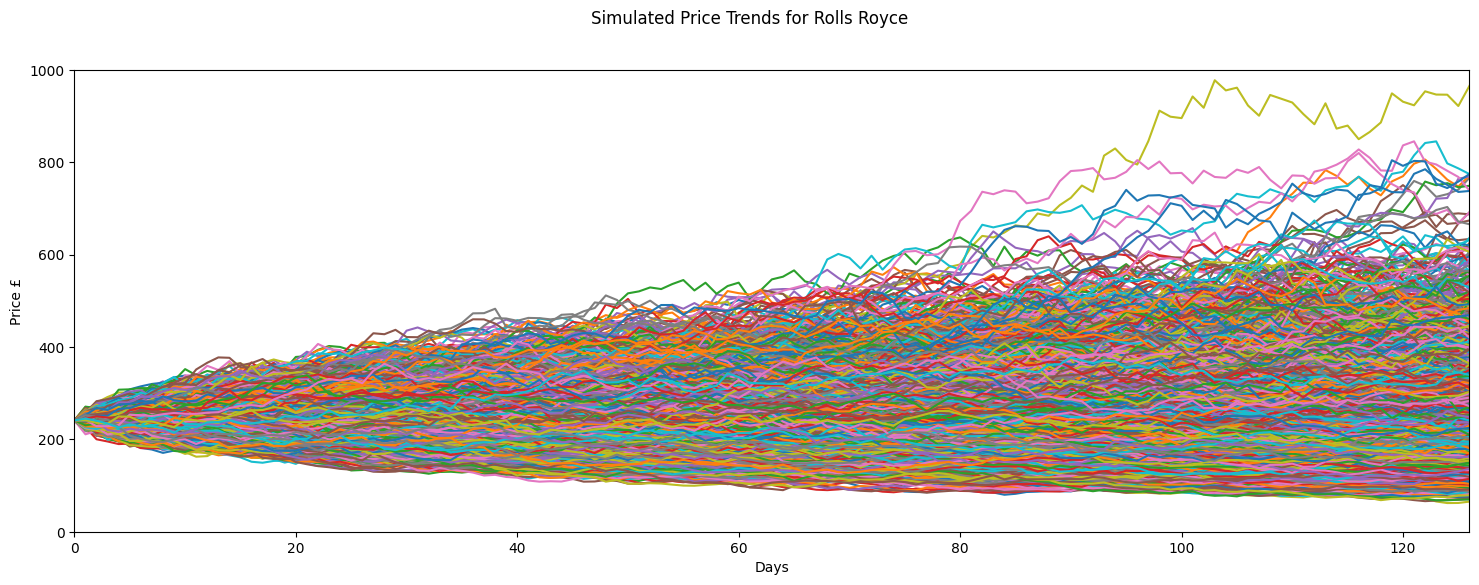

In [662]:
fig = plt.figure(figsize=(18,6))
plt.plot(stocks_simulation)
fig.suptitle('Simulated Price Trends for Rolls Royce')
plt.xlim(0,int(maturity*252))
plt.ylim(0,1000)
plt.xlabel('Days')
plt.ylabel('Price £')
plt.show()

In [663]:
stocks_simulation = np.transpose(stocks_simulation)
stocks_simulation.round(4)

array([[241.    , 240.1505, 235.347 , ..., 243.1998, 251.9157, 253.7349],
       [241.    , 237.4115, 234.383 , ..., 212.5113, 211.8269, 205.3033],
       [241.    , 237.9288, 243.919 , ..., 353.1569, 339.2352, 342.2717],
       ...,
       [241.    , 238.8858, 239.1033, ..., 150.9671, 149.2384, 155.017 ],
       [241.    , 241.5422, 235.7958, ..., 156.1711, 151.1766, 153.989 ],
       [241.    , 244.9139, 240.3724, ..., 340.8456, 344.8104, 339.3764]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

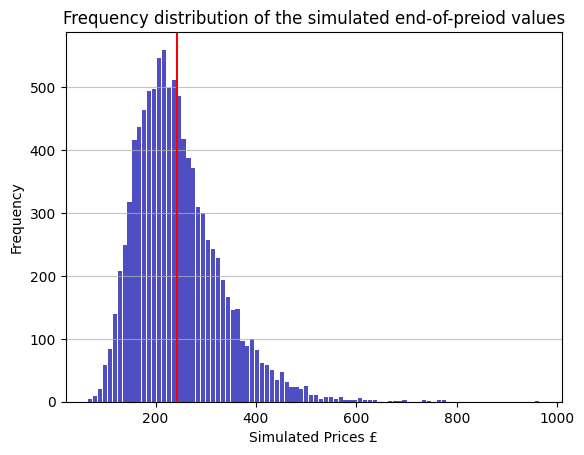

In [664]:
# Histogram formatting to visualize the distribution of the simulated stock prices on the last day

n, bins, patches = plt.hist(x=stocks_simulation[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.axvline(stocks_simulation.mean(), color='r', label='mean')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Simulated Prices £')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [665]:
# Computation of the option price from the simulated stock prices

MS_price = np.mean(np.maximum(K - stocks_simulation[:,-1],0))
print('Rolls Royce European Put Option Price with Binomial Tree model--> ', str(MS_price.round(4)))

Rolls Royce European Put Option Price with Binomial Tree model-->  12.6364


# Greeks Analysis

## Delta

In [666]:
def delta(stock_price, strike_price, maturity, risk_rate, dividend, volatility, payoff):
    T = maturity
    r = risk_rate

    d1 = (np.log(stock_price / strike_price) + (r - dividend + 0.5 * volatility ** 2) * T) / (volatility * np.sqrt(T))
    
    if payoff == "call":
        delta = np.exp(-dividend * T) * norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta = -np.exp(-dividend * T) * norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [667]:
_delta = delta(stock_price=S0,strike_price=K,maturity=maturity,risk_rate=r,dividend=0,volatility=sigma,payoff=payoff)
print(f'Delta value for Rolls Royce BSM European Put Option is --> {_delta.round(4)}')

Delta value for Rolls Royce BSM European Put Option is --> -0.2273


In [668]:
sample_prices = np.linspace(50,350,100)
Delta_Put = np.zeros((len(sample_prices),1))
for i in range(len(sample_prices)):
    Delta_Put [i] = delta(sample_prices[i], strike_price=K, maturity=maturity, risk_rate=r, dividend=0, volatility=sigma, payoff=payoff)

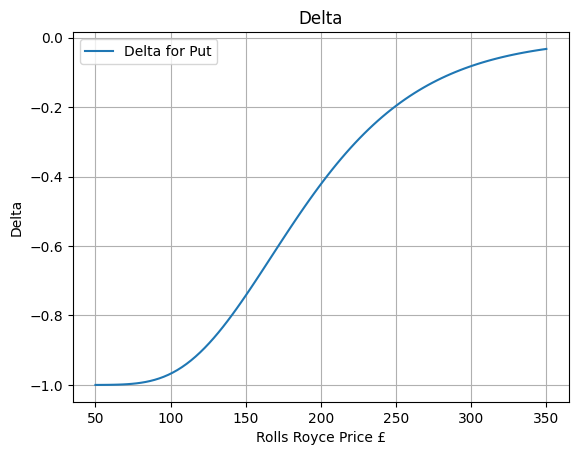

In [669]:
# Delta line chart formatting

fig = plt.figure()

plt.plot(sample_prices, Delta_Put, '-')
plt.grid()
plt.xlabel('Rolls Royce Price £')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Put'])

In [670]:

sample_times = np.linspace(0.1, 4, 100)
Delta1 = np.zeros((len(sample_times),len(sample_prices)))
for j in range(len(sample_prices)):
    for i in range(len(sample_times)):
        Delta1[i,j] = delta(stock_price=sample_prices[j], strike_price=K, maturity=sample_times[i], risk_rate=r, dividend=0, volatility=sigma, payoff=payoff)

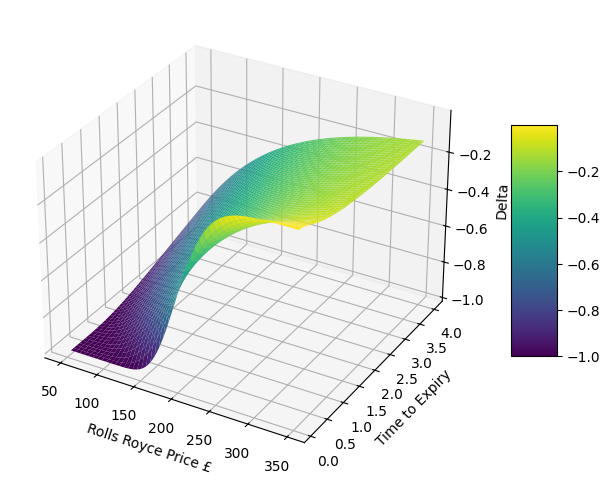

In [671]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
coord_prices, coord_times = np.meshgrid(sample_prices, sample_times)
surf = ax.plot_surface(coord_prices, coord_times, Delta1, rstride=2, cstride=2, cmap=plt.cm.viridis, linewidth=0.5, antialiased=True)
ax.set_xlabel('Rolls Royce Price £')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Gamma

In [672]:

def gamma(stock_price, strike_price, maturity, risk_rate, dividend, volatility, payoff):
    
    d1 = (np.log(stock_price / strike_price) + (risk_rate - dividend + 0.5 * volatility ** 2) * maturity) / (volatility * np.sqrt(maturity))
    
    gamma = np.exp(-dividend * maturity) * norm.pdf(d1, 0.0, 1.0) / (volatility * stock_price * np.sqrt(maturity))
    
    return gamma

In [673]:
_gamma = gamma(stock_price=S0, strike_price=K, maturity=maturity, risk_rate=r, dividend=0, volatility=sigma, payoff=payoff)
print(f'Gamma value for Rolls Royce BSM European Put Option is --> {_gamma.round(4)}')

Gamma value for Rolls Royce BSM European Put Option is --> 0.0037


In [674]:
Gamma1 = np.zeros((len(sample_prices),1))
for i in range(len(sample_prices)):
    Gamma1[i,0] = gamma(stock_price=sample_prices[i], strike_price=K, maturity=maturity, risk_rate=r, dividend=0, volatility=sigma, payoff=payoff)

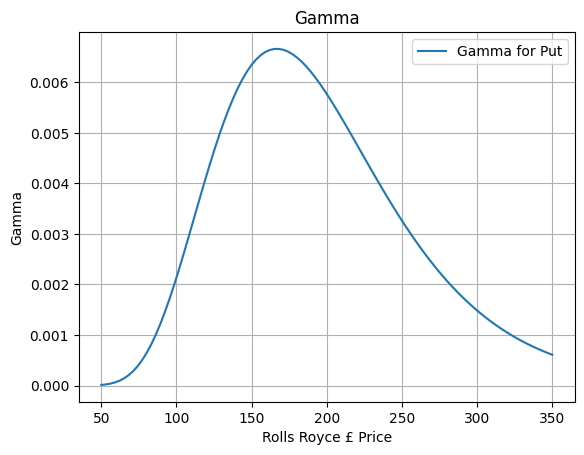

In [675]:
fig = plt.figure()
plt.plot(sample_prices, Gamma1, '-')
plt.grid()
plt.xlabel('Rolls Royce £ Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Put'])

In [676]:
Gamma1 = np.zeros((len(sample_times),len(sample_prices)))
for j in range(len(sample_prices)):
    for i in range(len(sample_times)):
        Gamma1[i,j] = gamma(stock_price=sample_prices[j], strike_price=K, maturity=sample_times[i], risk_rate=r, dividend=0, volatility=sigma, payoff=payoff)

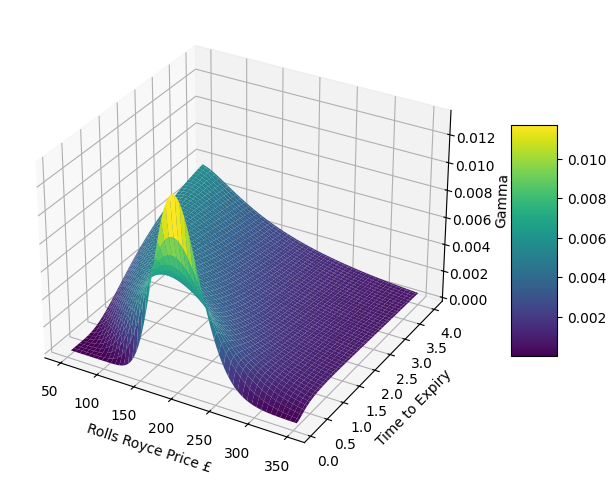

In [677]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(coord_prices, coord_times, Gamma1, rstride=2, cstride=2, cmap=plt.cm.viridis, linewidth=0.5, antialiased=True)
ax.set_xlabel('Rolls Royce Price £')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Theta

In [678]:
def theta(stock_price, strike_price, maturity, risk_rate, dividend, volatility, payoff):
   
    d1 = (np.log(stock_price / strike_price) + (risk_rate - dividend + 0.5 * volatility ** 2) * maturity) / (volatility * np.sqrt(maturity))
    d2 = (np.log(stock_price / strike_price) + (risk_rate - dividend - 0.5 * volatility ** 2) * maturity) / (volatility * np.sqrt(maturity))

    if payoff == "call":
        theta = (volatility * stock_price * np.exp(-dividend * maturity) * norm.pdf(d1, 0.0, 1.0)) / (2 * np.sqrt(maturity)) - dividend * stock_price * np.exp(-dividend * maturity) * norm.cdf(d1, 0.0, 1.0) + r * strike_price * np.exp(-r * maturity) * norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = (volatility * stock_price * np.exp(-dividend * maturity) * norm.pdf(-d1, 0.0, 1.0)) / (2 * np.sqrt(maturity)) - dividend * stock_price * np.exp(-dividend * maturity) * norm.cdf(-d1, 0.0, 1.0) + r * strike_price * np.exp(-r * maturity) * norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [679]:
_theta = theta(stock_price=S0, strike_price=K, maturity=T, risk_rate=r, dividend=0, volatility=sigma, payoff=payoff)
print(f'Theta value for Rolls Royce BSM European Put Option is --> {_theta.round(4)}')

Theta value for Rolls Royce BSM European Put Option is --> 26.3382


In [680]:
#Theta_Call = np.zeros((len(sample_times),1))
Theta_Put = np.zeros((len(sample_times),1))
for i in range(len(sample_times)):
    Theta_Put [i] = theta(stock_price=S0, strike_price=K, maturity=sample_times[i], risk_rate=r, dividend=0, volatility=sigma, payoff=payoff)

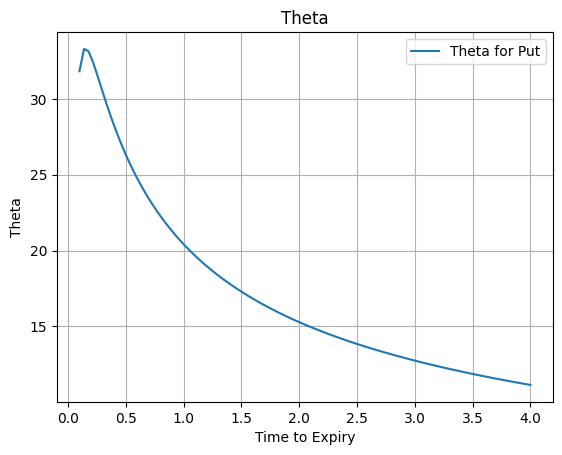

In [681]:
fig = plt.figure()
plt.plot(sample_times, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Put'])

In [682]:
Theta1 = np.zeros((len(sample_times),len(sample_prices)))
for j in range(len(sample_prices)):
    for i in range(len(sample_times)):
        Theta1[i,j] = theta(stock_price=sample_prices[j], strike_price=K, maturity=sample_times[i], risk_rate=r, dividend=0, volatility=sigma, payoff=payoff)

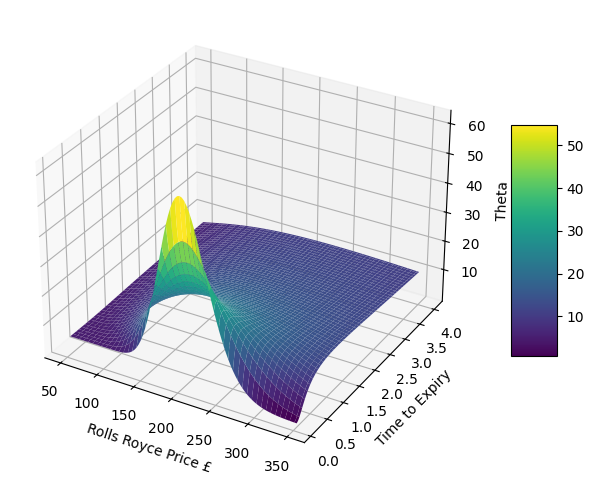

In [683]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(coord_prices, coord_times, Theta1, rstride=2, cstride=2, cmap=plt.cm.viridis, linewidth=0.5, antialiased=True)
ax.set_xlabel('Rolls Royce Price £')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Rho

In [684]:
def rho(stock_price, strike_price, maturity, risk_rate, dividend, volatility, payoff):
   
    d1 = (np.log(stock_price / strike_price) + (risk_rate - dividend + 0.5 * volatility ** 2) * maturity) / (volatility * np.sqrt(maturity))
    d2 = (np.log(stock_price / strike_price) + (risk_rate - dividend - 0.5 * volatility ** 2) * maturity) / (volatility * np.sqrt(maturity))
    
    if payoff == "call":
        rho = strike_price * maturity * np.exp(-risk_rate * maturity) * norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = -strike_price * maturity * np.exp(-risk_rate * maturity) * norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [685]:
_rho = rho(stock_price=S0, strike_price=K, maturity=T, risk_rate=r, dividend=0, volatility=sigma, payoff=payoff)
print(f'Rho value for Rolls Royce BSM European Put Option is --> {_rho.round(4)}')

Rho value for Rolls Royce BSM European Put Option is --> -33.8186


In [686]:
sample_rates = np.linspace(0.01,0.1,50)
# Rho_Call = np.zeros((len(rate_samples),1))
Rho_Put = np.zeros((len(sample_rates),1))
for i in range(len(sample_rates)):
    Rho_Put [i] = rho(stock_price=S0, strike_price=K, maturity=T, risk_rate=sample_rates[i], dividend=0, volatility=sigma, payoff=payoff)

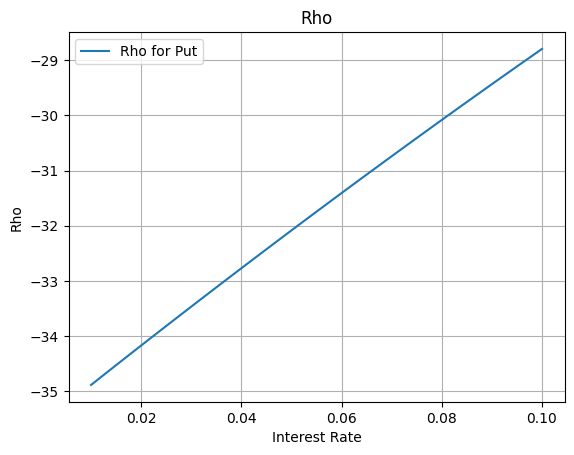

In [687]:
fig = plt.figure()
plt.plot(sample_rates, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend([ 'Rho for Put'])

In [688]:
Rho3 = np.zeros((len(sample_times),len(sample_prices)))
for j in range(len(sample_prices)):
    for i in range(len(sample_times)):
        Rho3[i,j] = rho(stock_price=sample_prices[j], strike_price=K, maturity=sample_times[i], risk_rate=r, dividend=0, volatility=sigma, payoff=payoff)

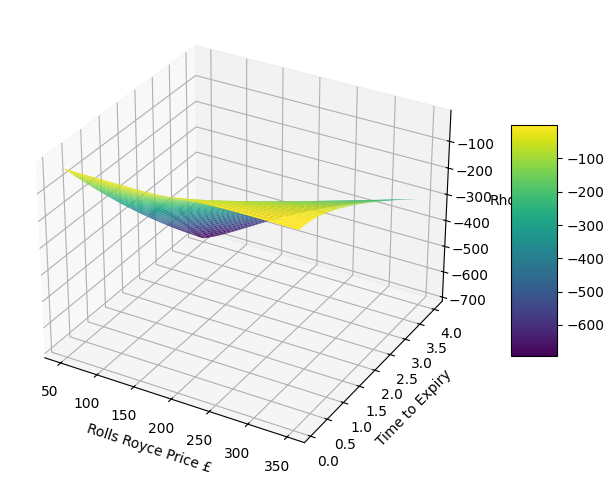

In [689]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(coord_prices, coord_times, Rho3, rstride=2, cstride=2, cmap=plt.cm.viridis, linewidth=0.5, antialiased=True)
ax.set_xlabel('Rolls Royce Price £')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Vega

In [690]:
def vega(stock_price, strike_price, maturity, risk_rate, dividend, volatility, payoff):
  
    d1 = (np.log(stock_price / strike_price) + (risk_rate - dividend + 0.5 * volatility ** 2) * maturity) / (volatility * np.sqrt(maturity))
    vega = stock_price * np.sqrt(maturity) * np.exp(-dividend * maturity) * norm.pdf(d1, 0.0, 1.0)
    
    return vega


In [691]:
_vega = vega(stock_price=S0, strike_price=K, maturity=T, risk_rate=r, dividend=0, volatility=sigma, payoff=payoff)
print(f'Vega value for Rolls Royce BSM European Put Option is --> {_vega.round(4)}')

Vega value for Rolls Royce BSM European Put Option is --> 51.4095


In [692]:
sample_vol = np.linspace(0.5,1.5,50)
Vega = np.zeros((len(sample_vol),1))
for i in range(len(sample_vol)):
    Vega [i] = vega(stock_price=S0, strike_price=K, maturity=T, risk_rate=r, dividend=0, volatility=sample_vol[i], payoff=payoff)

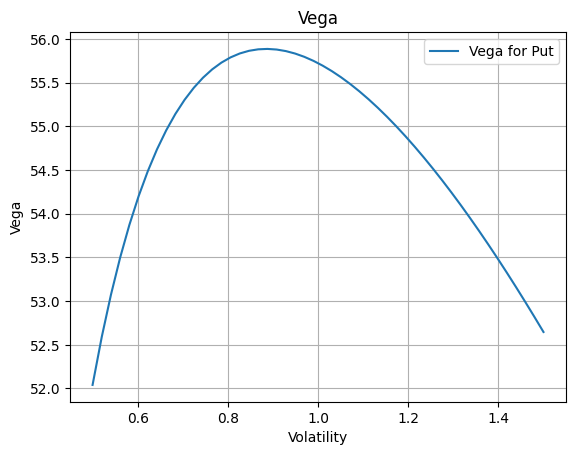

In [693]:
fig = plt.figure()
plt.plot(sample_vol, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Put'])

In [694]:
Vega2 = np.zeros((len(sample_times),len(sample_prices)))
for j in range(len(sample_prices)):
    for i in range(len(sample_times)):
        Vega2[i,j] = vega(stock_price=sample_prices[j], strike_price=K, maturity=sample_times[i] , risk_rate=r, dividend=0, volatility=sigma, payoff=payoff)

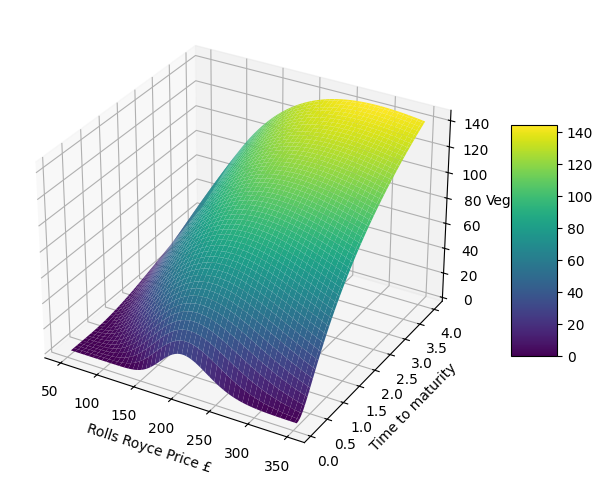

In [695]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(coord_prices, coord_times, Vega2, rstride=2, cstride=2, cmap=plt.cm.viridis, linewidth=0.5, antialiased=True)
ax.set_xlabel('Rolls Royce Price £')
ax.set_ylabel('Time to maturity')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);